In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2022-06-29 12:50:11.248511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 12:50:11.248525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-29 12:50:12.708161: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 12:50:12.728656: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 12:50:12.730595: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_lo

In [2]:
img = tf.image.decode_jpeg(
    tf.io.read_file('./catdog.jpg'))


2022-06-29 12:50:13.874220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 12:50:13.874242: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 12:50:13.874255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yf-nnw-arch): /proc/driver/nvidia/version does not exist
2022-06-29 12:50:13.874485: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
img.shape

TensorShape([561, 728, 3])

In [4]:
def draw_ab(images, boxes):
    images = tf.cast(images, dtype='float32')
    if len(images.shape) == 3:
        images = tf.reshape(images, shape=(1, *images.shape))
    if len(boxes.shape) == 1:
        boxes = tf.reshape(boxes, shape=(1, 1, *boxes.shape))
    elif len(boxes.shape) == 2:
        boxes = tf.reshape(boxes, shape=(1, *boxes.shape))
    colors = tf.random.uniform(shape=(*boxes.shape[:2], 4),
                               minval=0,
                               maxval=255,
                               dtype='float32')
    colors = tf.reshape(colors, (-1, 4))
    return tf.image.draw_bounding_boxes(images=images,
                                        boxes=boxes,
                                        colors=colors)


def im_show(images):
    [plt.imshow(tf.cast(images[i], dtype='int32')) for i in range(len(images))]

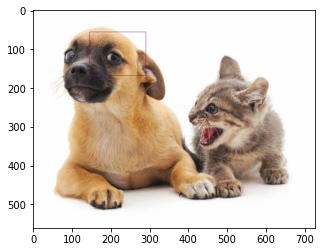

In [5]:
boxed = draw_ab(img, tf.constant([0.1, 0.2, 0.3, 0.4], dtype='float32')) # h, w
im_show(boxed)

In [6]:

def get_all_boxes(imgs, scales, ratios):
    """
        imgs：图片集合，shape=(batch_size, h, w, c)
        scales: 缩放大小集合
        ratios: 比例大小集合
        对图片的每个像素都是生成（s1, r1）, (s1, r2), .... (s1, rm), (s2, r1), (s3, r1), ..., (sn, r1)个box
        总共生成 h * w * boxes_per_pixel 个 box
    """
    boxes_per_pixel = len(scales) + len(ratios) - 1
    pairs = [(scale, ratios[0]) for scale in scales]
    pairs += [(scales[0], ratio) for ratio in ratios[1:]]
    h_pos, w_pos = 0, 1
    if len(imgs.shape) != 3:
        h_pos += 1
        w_pos += 1
    img_h, img_w = imgs.shape[h_pos], imgs.shape[w_pos]
    # scales, ratios = tf.constant(scales, dtype='float32'), tf.constant(ratios, dtype='float32')
    # 先生成每个sr的中心， center_h.shape=(400,) center_w.shape=(796,)
    center_h, center_w = tf.range(img_h, dtype='float32'), tf.range(img_w, dtype='float32')
    # center = tf.transpose(tf.stack(tf.meshgrid(center_h, center_w)))
    # center.shape=(400, 796, 2, 6)
    # center = tf.repeat(tf.expand_dims(center, axis=-1), repeats=boxes_per_pixel, axis=-1)
    # print(center)
    boxes = []
    # 根据中心计算box的左上角和右下角的坐标
    for (scale, ratio) in pairs:
        # if i == 0:
        # for j, ratio in enumerate(ratios):
        box_h = img_h * scale / tf.sqrt(ratio) / 2
        box_w = img_w * scale * tf.sqrt(ratio) / 2
        lt_h = (center_h - box_h) / img_h
        lt_w = (center_w - box_w) / img_w
        rb_h = (center_h + box_h) / img_h
        rb_w = (center_w + box_w) / img_w
        lt = tf.transpose(tf.stack(tf.meshgrid(lt_h, lt_w)))
        rb = tf.transpose(tf.stack(tf.meshgrid(rb_h, rb_w)))
        # b.shape=(400, 796, 4)
        b = tf.concat((lt, rb), axis=-1)
        boxes.append(b)
    return tf.stack(boxes)
        


In [7]:
boxes = get_all_boxes(imgs=img, scales=[.75, .5, .25], ratios=[1., 2., .5, .25])


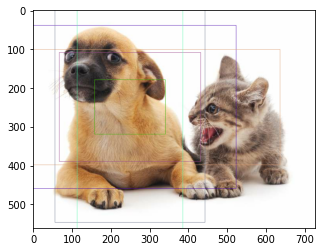

In [8]:
boxed = draw_ab(images=img, boxes=boxes[:, 250, 250,:])
im_show(boxed)

In [9]:
def box_iou(boxes1, boxes2):
    """
        交并比
        boxes.shape=(?, 4)
                0                   1                   2                   3
        box: (left_upper_height, left_upper_weight, right_lower_height, right_lower_weight)
    """
    get_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    area1 = get_area(boxes1)
    area2 = get_area(boxes2)
    # 求交集面积
    inter_lu = tf.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_rl = tf.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inter_area = (inter_rl[:, :, 0] - inter_lu[:, :, 0]) * (inter_rl[:, :, 1] - inter_lu[:, :, 1])
    # inter_area = get_area(tf.concat((inter_lu, inter_rl), axis=-1))
    inter_area = tf.clip_by_value(inter_area, clip_value_min=0, clip_value_max=1e9)
    # 求并集面积
    # area1, area2 = tf.meshgrid(area2, area1)
    union_area = area1[:, None] + area2 - inter_area
    return inter_area / union_area

In [10]:
boxes1 = boxes[:, 250, 250, :]
# print(boxes1)
boxes2 = tf.constant([[.1, .08, .52, .92]])
# print(boxes2)
box_iou(boxes1=boxes1, boxes2=boxes2)
# 
# ground_truth = tf.constant([[0, .1, .08, .52, .92], [1, .55, .2, .9, .88]])


<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.41431323],
       [0.3680834 ],
       [0.13638166],
       [0.41731012],
       [0.3202079 ],
       [0.20783849]], dtype=float32)>

In [11]:
ground_truth = tf.constant([[0, .1, .08, .52, .92], [1, .55, .2, .9, .88]])
anchors = tf.constant([[0, .1, .2, .3], [.15, .2, .4, .4], [.63, .05, .88, .98], [.66, .45, .8, .8], [.57, .3, .92, .9], [.099, .078, .50, .93], [.53, .21, .88, .70]])
# anchors = tf.constant([[.099, .078, .50, .93], [.53, .21, .88, .88]])
box_iou(anchors, ground_truth[:, 1:])


<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[0.05364807, 0.        ],
       [0.14172335, 0.        ],
       [0.        , 0.56572384],
       [0.        , 0.20588237],
       [0.        , 0.745908  ],
       [0.937364  , 0.        ],
       [0.        , 0.65254235]], dtype=float32)>

In [12]:
def assign_anchor_to_bbox(ground_truth, anchors, threshold=.5):
    n_anchors, n_ground_truth = anchors.shape[0], ground_truth.shape[0]
    iou = box_iou(anchors, ground_truth)
    # iou = tf.where(iou > threshold, iou)
    iou = np.array(iou)
    # iou = iou.asnumpy()
    # iou = tf.Variable(initial_value=iou, trainable=False)
    col_discard = tf.constant(value=-1, dtype='float32', shape=(n_ground_truth))
    row_discard = tf.constant(value=-1, dtype='float32', shape=(n_anchors))
    # anchor_bbox_map = dict()
    anchor_bbox_map = np.full((n_anchors,), fill_value=-1)
    # anchor_bbox_map = tf.Variable(initial_value=tf.fill((n_anchors), -1), shape=(n_anchors,), trainable=False, dtype='int32')
    # max_ious, indics = tf.reduce_max(iou, axis=1), tf.argmax(iou, axis=1)
    # max_ious = tf.Variable(initial_value=max_ious, trainable=False)
    for _ in range(n_ground_truth):
        maximum_row = tf.argmax(iou, axis=0)
        anc_idx = tf.reduce_max(maximum_row)
        maximum_col = tf.argmax(iou[anc_idx, :])
        gt_idx = tf.reduce_max(maximum_col)
        if iou[anc_idx, gt_idx] < threshold:
            break
        anchor_bbox_map[anc_idx] = gt_idx
        iou[anc_idx, :] = col_discard
        iou[:, gt_idx] = row_discard
    return tf.constant(anchor_bbox_map)
    # print(indics)

In [13]:
assign_anchor_to_bbox(ground_truth[:, 1:], anchors)

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([-1, -1, -1, -1,  1,  0, -1])>

In [14]:
def offset_boxes(ground_truth, anchors, eps=1e-6):
    def corner_to_center(box):
        # lh, lw ,rh ,rw
        ch, cw = (box[:, 0] + box[:, 2]) / 2, (box[:, 1] + box[:, 3]) / 2
        h, w = box[:, 2] - box[:, 0], box[:, 3] - box[:, 1]
        return tf.stack((ch, cw, h, w), axis=-1)
    c_anc = corner_to_center(anchors)
    c_gt = corner_to_center(ground_truth)
    offset_xy = 10 * (c_gt[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_hw = 5 * tf.math.log(eps + c_gt[:, 2:] / c_anc[:, 2:])
    return tf.concat((offset_xy, offset_hw), axis=-1)
    

In [15]:
def multibox_target(ground_truth, anchors):
    offsets, masks, labels = [], [], []
    # n_anchors = anchors.shape[0]
    # zero_mask = tf.zeros(shape=(n_anchors, 4))
    # one_mask = tf.zeros(shape=(n_anchors, 4))
    for i in range(len(ground_truth)):
        label = ground_truth[i, :, :]
        label = np.array(label)
        # label = tf.expand_dims(label, axis=0)
        anchor_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        anchor_bbox_map = np.array(anchor_bbox_map)
        indicates, = tf.experimental.numpy.nonzero(anchor_bbox_map >= 0)
        # anchor_bbox_map.shape=(n_anchors, )
        # _mask.shape=(n_anchors, 4)
        # print(indicates)
        if len(indicates) == 0:
            continue
        # _mask = tf.where(tf.repeat(tf.expand_dims(anchor_bbox_map >= 0, axis=-1), 4, axis=-1), one_mask, zero_mask)
        _mask = tf.cast(tf.repeat(tf.expand_dims(anchor_bbox_map >= 0, axis=-1), 4, axis=-1), dtype='float32')
        bbox_indicates = anchor_bbox_map[np.array(indicates)]
        # print(bbox_indicates)
        _bbox = np.zeros((anchors.shape[0], 4), dtype='float32')
        _class = np.full((anchors.shape[0], 1), -1, dtype='int32')
        _class[indicates, :] = label[bbox_indicates, :1]
        _bbox[indicates, :] = label[bbox_indicates, 1:]
        _offset = offset_boxes(_bbox, anchors) * _mask
        offsets.append(_offset)
        labels.append(_class)
        masks.append(_mask)
    return tf.stack(offsets), tf.stack(masks), tf.stack(labels)
    

In [16]:
offsets, masks, labels = multibox_target(tf.expand_dims(ground_truth, 0), anchors)

In [17]:
def offset_inverse(anchors, offsets):
    def corner_to_center(box):
        # lh, lw ,rh ,rw
        ch, cw = (box[:, 0] + box[:, 2]) / 2, (box[:, 1] + box[:, 3]) / 2
        h, w = box[:, 2] - box[:, 0], box[:, 3] - box[:, 1]
        return tf.stack((ch, cw, h, w), axis=-1)
    c_anc = corner_to_center(anchors)
    pred_xy = (offsets[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    pred_wh = tf.exp(offsets[:, 2:] / 5) * c_anc[:, 2:]
    pred = tf.concat((pred_xy, pred_wh), axis=-1)
    def center_to_corner(box):
        half_h, half_w = box[:, 2] / 2., box[:, 3] / 2.
        return tf.stack((box[:, 0] - half_h, box[:, 0] + half_h, box[:, 1] - half_w, box[:, 1] + half_w), axis=-1)
    return center_to_corner(pred)
    

In [18]:
offset_inverse(anchors, offsets[0, :, :])

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.        , 0.2       , 0.09999999, 0.3       ],
       [0.15      , 0.4       , 0.20000002, 0.4       ],
       [0.63      , 0.88      , 0.04999998, 0.98      ],
       [0.66      , 0.8       , 0.45      , 0.8       ],
       [0.54999983, 0.9000002 , 0.19999972, 0.88000035],
       [0.09999982, 0.5200002 , 0.07999954, 0.92000043],
       [0.53      , 0.88      , 0.20999998, 0.7       ]], dtype=float32)>

In [19]:
def scaled_anchors(fmap_h, fmap_w, scales, h, w):
    fmap = tf.zeros((1, fmap_h, fmap_w, 10), dtype='float32')
    anchors = get_all_boxes(fmap, scales=scales, ratios=[1., 2., .5])
    bbox_scale = tf.constant((h, w, h, w), dtype='float32')
    # scaled = anchors * bbox_scale
    return anchors

h, w = img.shape[:2]
boxes2 = scaled_anchors(4, 4, scales=[.15], h=h, w=w)
boxed2 = draw_ab(img, tf.reshape(boxes2, shape=(-1,4)))
# im_show(boxed2)
    

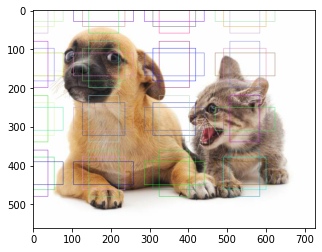

In [20]:
im_show(boxed2)

In [21]:
img[0, :, :].shape

TensorShape([728, 3])